# Neural Network (Multilayer Perceptron) Demo

_Source: 🤖[Homemade Machine Learning](https://github.com/trekhleb/homemade-machine-learning) repository_

> ☝Before moving on with this demo you might want to take a look at:
> - 📗[Math behind the Neural Networks](https://github.com/trekhleb/homemade-machine-learning/tree/master/homemade/neural_network)
> - ⚙️[Neural Network Source Code](https://github.com/trekhleb/homemade-machine-learning/blob/master/homemade/neural_network/multilayer_perceptron.py)

**Artificial neural networks (ANN)** or connectionist systems are computing systems vaguely inspired by the biological neural networks that constitute animal brains. The neural network itself isn't an algorithm, but rather a framework for many different machine learning algorithms to work together and process complex data inputs. Such systems "learn" to perform tasks by considering examples, generally without being programmed with any task-specific rules.

A **multilayer perceptron (MLP)** is a class of feedforward artificial neural network. An MLP consists of, at least, three layers of nodes: an input layer, a hidden layer and an output layer. Except for the input nodes, each node is a neuron that uses a nonlinear activation function. MLP utilizes a supervised learning technique called backpropagation for training. Its multiple layers and non-linear activation distinguish MLP from a linear perceptron. It can distinguish data that is not linearly separable.

> **Demo Project:** In this example we will train clothes classifier that will recognize clothes types (10 categories) from `28x28` pixel images using simple multilayer perceptron.

In [1]:
# To make debugging of multilayer_perceptron module easier we enable imported modules autoreloading feature.
# By doing this you may change the code of multilayer_perceptron library and all these changes will be available here.
%load_ext autoreload
%autoreload 2

# Add project root folder to module loading paths.
import sys
sys.path.append('../..')

### Import Dependencies

- [pandas](https://pandas.pydata.org/) - library that we will use for loading and displaying the data in a table
- [numpy](http://www.numpy.org/) - library that we will use for linear algebra operations
- [matplotlib](https://matplotlib.org/) - library that we will use for plotting the data
- [math](https://docs.python.org/3/library/math.html) - math library that we will use to calculate sqaure roots etc.
- [neural_network](https://github.com/trekhleb/homemade-machine-learning/blob/master/homemade/neural_network/multilayer_perceptron.py) - custom implementation of multilayer perceptron

In [2]:
# Import 3rd party dependencies.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

# Import custom multilayer perceptron implementation.
from homemade.neural_network import MultilayerPerceptron

### Load the Data

In this demo we will use a sample of [Fashion MNIST dataset in a CSV format](https://www.kaggle.com/zalando-research/fashionmnist).

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

Instead of using full dataset with 60000 training examples we will use cut dataset of just 5000 examples that we will also split into training and testing sets.

Each row in the dataset consists of 785 values: the first value is the label (a category from 0 to 9) and the remaining 784 values (28x28 pixels image) are the pixel values (a number from 0 to 255).

Each training and test example is assigned to one of the following labels:

- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot

In [3]:
# Load the data.
data = pd.read_csv('../../data/fashion-mnist-demo.csv')

# Laets create the mapping between numeric category and category name.
label_map = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot',
}

# Print the data table.
data.head(10)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4,0,0,0,5,4,5,5,3,5,...,7,8,7,4,3,7,5,0,0,0
6,4,0,0,0,0,0,0,0,0,0,...,14,0,0,0,0,0,0,0,0,0
7,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,4,0,0,0,0,0,0,3,2,0,...,1,0,0,0,0,0,0,0,0,0
9,8,0,0,0,0,0,0,0,0,0,...,203,214,166,0,0,0,0,0,0,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 29.9 MB


### Plot the Data

Let's peek first 25 rows of the dataset and display them as an images to have an example of clothes we will be working with.

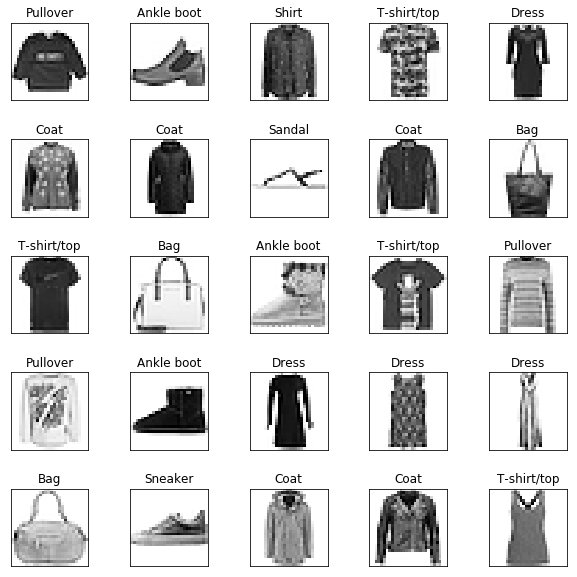

In [5]:
# How many images to display.
numbers_to_display = 25

# Calculate the number of cells that will hold all the images.
num_cells = math.ceil(math.sqrt(numbers_to_display))

# Make the plot a little bit bigger than default one.
plt.figure(figsize=(10, 10))

# Go through the first images in a training set and plot them.
for plot_index in range(numbers_to_display):
    # Extract image data.
    digit = data[plot_index:plot_index + 1].values
    digit_label = digit[0][0]
    digit_pixels = digit[0][1:]

    # Calculate image size (remember that each picture has square proportions).
    image_size = int(math.sqrt(digit_pixels.shape[0]))
    
    # Convert image vector into the matrix of pixels.
    frame = digit_pixels.reshape((image_size, image_size))
    
    # Plot the image matrix.
    plt.subplot(num_cells, num_cells, plot_index + 1)
    plt.imshow(frame, cmap='Greys')
    plt.title(label_map[digit_label])
    plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

# Plot all subplots.
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

### Split the Data Into Training and Test Sets

In this step we will split our dataset into _training_ and _testing_ subsets (in proportion 80/20%).

Training data set will be used for training of our model. Testing dataset will be used for validating of the model. All data from testing dataset will be new to model and we may check how accurate are model predictions.

In [6]:
# Split data set on training and test sets with proportions 80/20.
# Function sample() returns a random sample of items.
pd_train_data = data.sample(frac=0.8)
pd_test_data = data.drop(pd_train_data.index)

# Convert training and testing data from Pandas to NumPy format.
train_data = pd_train_data.values
test_data = pd_test_data.values

# Extract training/test labels and features.
num_training_examples = 1000

x_train = train_data[:num_training_examples, 1:]
y_train = train_data[:num_training_examples, [0]]

x_test = test_data[:, 1:]
y_test = test_data[:, [0]]

### Init and Train MLP Model

> ☝🏻 This is the place where you might want to play with model configuration.

> ⚠️ Be aware though that the training of the neural network with current parameters may take up to 15 minutes depending on the hardware. 

- `layers` - configuration of the multilayer perceptron layers (array of numbers where every number represents the number of nayron in specific layer).
- `max_iterations` - this is the maximum number of iterations that gradient descent algorithm will use to find the minimum of a cost function. Low numbers may prevent gradient descent from reaching the minimum. High numbers will make the algorithm work longer without improving its accuracy.
- `regularization_param` - parameter that will fight overfitting. The higher the parameter, the simplier is the model will be.
- `normalize_data` - boolean flag that indicates whether data normalization is needed or not.
- `alpha` - the size of gradient descent steps. You may need to reduce the step size if gradient descent can't find the cost function minimum. 

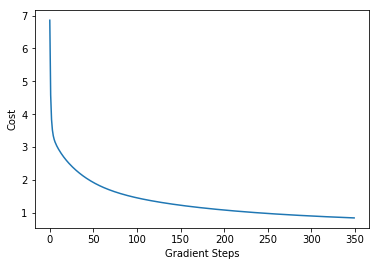

In [7]:
# Configure neural network.
layers = [
    784, # Input layer - 28x28 input pixels.
    25,  # First hidden layer - 25 hidden units.
    10,  # Output layer - 10 labels, from 0 to 9.
];
normalize_data = True  # Flag that detects whether we want to do features normalization or not.
epsilon = 0.12  # Defines the range for initial theta values.
max_iterations = 350  # Max number of gradient descent iterations.
regularization_param = 2  # Helps to fight model overfitting.
alpha = 0.1  # Gradient descent step size.

# Init neural network.
multilayer_perceptron = MultilayerPerceptron(x_train, y_train, layers, epsilon, normalize_data)

# Train neural network.
(thetas, costs) = multilayer_perceptron.train(regularization_param, max_iterations, alpha)

plt.plot(range(len(costs)), costs)
plt.xlabel('Gradient Steps')
plt.ylabel('Cost')
plt.show()

### Illustrate Hidden Layers Perceptrons

Each perceptron in the hidden layer learned something from the training process. What it learned is represented by input theta parameters for it. Each perceptron in the hidden layer has 28x28 input thetas (one for each input image pizel). Each theta represents how valuable each pixel is for this particuar perceptron. So let's try to plot how valuable each pixel of input image is for each perceptron based on its theta values.  

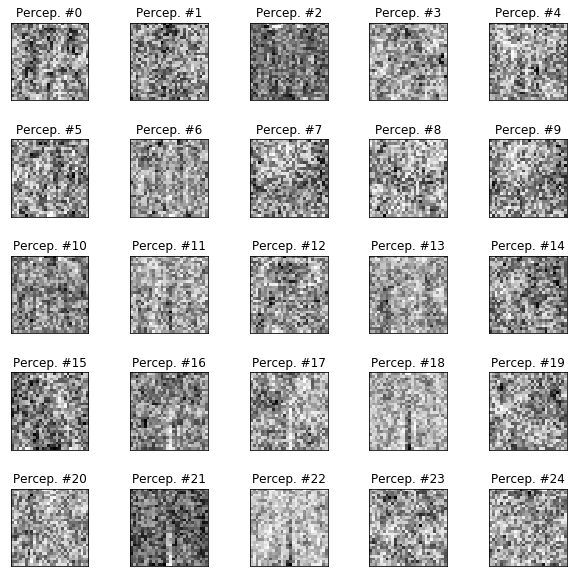

In [8]:
# Setup the number of layer we want to display.
# We want to display the first hidden layer.
layer_number = 1 

# How many perceptrons to display.
num_perceptrons = len(thetas[layer_number - 1])

# Calculate the number of cells that will hold all the images.
num_cells = math.ceil(math.sqrt(num_perceptrons))

# Make the plot a little bit bigger than default one.
plt.figure(figsize=(10, 10))

# Go through the perceptrons plot what they've learnt.
for perceptron_index in range(num_perceptrons):
    # Extract perceptron data.
    perceptron = thetas[layer_number - 1][perceptron_index][1:]

    # Calculate image size (remember that each picture has square proportions).
    image_size = int(math.sqrt(perceptron.shape[0]))
    
    # Convert image vector into the matrix of pixels.
    frame = perceptron.reshape((image_size, image_size))
    
    # Plot the image matrix.
    plt.subplot(num_cells, num_cells, perceptron_index + 1)
    plt.imshow(frame, cmap='Greys', vmin=np.amin(frame), vmax=np.amax(frame))
    plt.title('Percep. #%s' % perceptron_index)
    plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

# Plot all subplots.
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

### Calculate Model Training Precision

Calculate how many of training and test examples have been classified correctly. Normally we need test precission to be as high as possible. In case if training precision is high and test precission is low it may mean that our model is overfitted (it works really well with the training data set but it is not good at classifying new unknown data from the test dataset). In this case you may want to play with `regularization_param` parameter to fighth the overfitting.

In [9]:
# Make training set predictions.
y_train_predictions = multilayer_perceptron.predict(x_train)
y_test_predictions = multilayer_perceptron.predict(x_test)

# Check what percentage of them are actually correct.
train_precision = np.sum(y_train_predictions == y_train) / y_train.shape[0] * 100
test_precision = np.sum(y_test_predictions == y_test) / y_test.shape[0] * 100

print('Training Precision: {:5.4f}%'.format(train_precision))
print('Test Precision: {:5.4f}%'.format(test_precision))

Training Precision: 93.8000%
Test Precision: 80.6000%


### Plot Test Dataset Predictions

In order to illustrate how our model classifies unknown examples let's plot first 64 predictions for testing dataset. All green clothes on the plot below have been recognized correctly but all the red clothes have not been recognized correctly by our classifier. On top of each image you may see the class that has been recognized on the image.

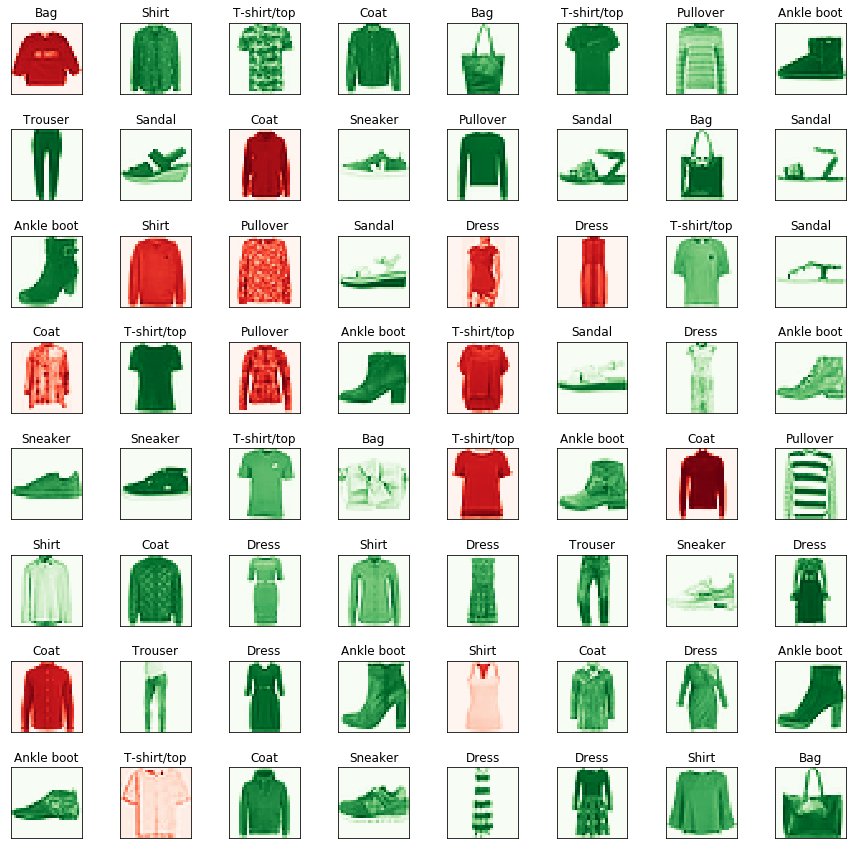

In [10]:
# How many images to display.
numbers_to_display = 64

# Calculate the number of cells that will hold all the images.
num_cells = math.ceil(math.sqrt(numbers_to_display))

# Make the plot a little bit bigger than default one.
plt.figure(figsize=(15, 15))

# Go through the first images in a test set and plot them.
for plot_index in range(numbers_to_display):
    # Extract digit data.
    digit_label = y_test[plot_index, 0]
    digit_pixels = x_test[plot_index, :]
    
    # Predicted label.
    predicted_label = y_test_predictions[plot_index][0]

    # Calculate image size (remember that each picture has square proportions).
    image_size = int(math.sqrt(digit_pixels.shape[0]))
    
    # Convert image vector into the matrix of pixels.
    frame = digit_pixels.reshape((image_size, image_size))
    
    # Plot the image matrix.
    color_map = 'Greens' if predicted_label == digit_label else 'Reds'
    plt.subplot(num_cells, num_cells, plot_index + 1)
    plt.imshow(frame, cmap=color_map)
    plt.title(label_map[predicted_label])
    plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

# Plot all subplots.
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()